# Imports

In [1]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import os
import os.path as osp
import copy

import json
import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import Counter
import itertools
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# from transformers import AutoTokenizer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

In [4]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from sentence_transformers import SentenceTransformer, util

In [6]:
stop_words = set(stopwords.words('english'))

# Read data

In [7]:
# function to read the data file

def read_data(path):
    fd = open(path, "rb")
    data = json.load(fd)
    fd.close()

    return data


In [8]:
data_path = "/content/ori_pqal.json"
data = read_data(data_path)

type(data), len(data)

(dict, 1000)

# View data

In [9]:
list(data.keys())[:5]

['21645374', '16418930', '9488747', '17208539', '10808977']

In [10]:
dict_key = '16418930'
dict_val = data[dict_key]
type(dict_val), len(dict_val)

(dict, 9)

In [11]:
for key, value in dict_val.items():
    print(key.ljust(20), "\t", str(type(value)).ljust(10), "\t", len(value) )

QUESTION             	 <class 'str'> 	 68
CONTEXTS             	 <class 'list'> 	 3
LABELS               	 <class 'list'> 	 3
MESHES               	 <class 'list'> 	 19
YEAR                 	 <class 'str'> 	 4
reasoning_required_pred 	 <class 'str'> 	 2
reasoning_free_pred  	 <class 'str'> 	 2
final_decision       	 <class 'str'> 	 2
LONG_ANSWER          	 <class 'str'> 	 231


In [12]:
for key, value in dict_val.items():
    print(key.ljust(20),  "\t", value )

QUESTION             	 Landolt C and snellen e acuity: differences in strabismus amblyopia?
CONTEXTS             	 ['Assessment of visual acuity depends on the optotypes used for measurement. The ability to recognize different optotypes differs even if their critical details appear under the same visual angle. Since optotypes are evaluated on individuals with good visual acuity and without eye disorders, differences in the lower visual acuity range cannot be excluded. In this study, visual acuity measured with the Snellen E was compared to the Landolt C acuity.', '100 patients (age 8 - 90 years, median 60.5 years) with various eye disorders, among them 39 with amblyopia due to strabismus, and 13 healthy volunteers were tested. Charts with the Snellen E and the Landolt C (Precision Vision) which mimic the ETDRS charts were used to assess visual acuity. Three out of 5 optotypes per line had to be correctly identified, while wrong answers were monitored. In the group of patients, the eyes

In [13]:
# parse the json file to turn it into dataframe

question_ll = []
answer_ll = []
context_ll = []
context_num_ll = []

labels_ll = []
meshes_ll = []
year_ll = []

reasoning_required_pred_ll = []
reasoning_free_pred_ll = []
final_decision_ll = []

for reord_id, record in data.items():
    question = record["QUESTION"]
    answer = record["LONG_ANSWER"]
    context = "\n".join( record["CONTEXTS"] ).strip()
    context_num = len( record["CONTEXTS"] )
    labels = record["LABELS"]
    mesh = record["MESHES"]
    year = record["YEAR"]
    reasoning_required_pred = record["reasoning_required_pred"]
    reasoning_free_pred = record["reasoning_free_pred"]
    final_decision = record["final_decision"]

    question_ll.append(question)
    answer_ll.append(answer)
    context_ll.append(context)
    context_num_ll.append(context_num)
    labels_ll += labels
    meshes_ll += mesh
    year_ll.append(year)
    reasoning_required_pred_ll.append(reasoning_required_pred)
    reasoning_free_pred_ll.append(reasoning_free_pred)
    final_decision_ll.append(final_decision)


df = pd.DataFrame({"question":question_ll, "answer":answer_ll, "context":context_ll })
df.shape

(1000, 3)

In [14]:
df.head()

,question,answer,context
0,Do mitochondria play a role in remodelling lac...,Results depicted mitochondrial dynamics in viv...,Programmed cell death (PCD) is the regulated d...
1,Landolt C and snellen e acuity: differences in...,"Using the charts described, there was only a s...",Assessment of visual acuity depends on the opt...
2,"Syncope during bathing in infants, a pediatric...","""Aquagenic maladies"" could be a pediatric form...",Apparent life-threatening events in infants ar...
3,Are the long-term results of the transanal pul...,Our long-term study showed significantly bette...,The transanal endorectal pull-through (TERPT) ...
4,Can tailored interventions increase mammograph...,The effects of the intervention were most pron...,Telephone counseling and tailored print commun...


# Analysis

### data content analysis

In [15]:
# total unqiue number of contexts per question
np.unique(context_num_ll)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

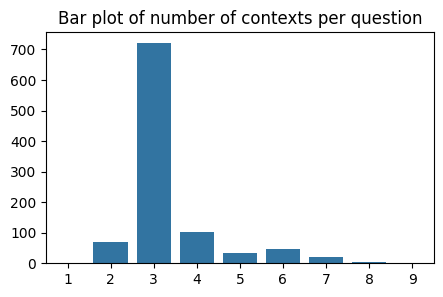

In [16]:
items, counts =  np.unique(context_num_ll, return_counts=True)

plt.figure(figsize=(5,3))
sns.barplot(x=items, y=counts,)
plt.title("Bar plot of number of contexts per question")
plt.show()

In [17]:
# see their actual numbers
for x,y in zip(items, counts):
    print(x, " - ", y)

1  -  1
2  -  69
3  -  720
4  -  101
5  -  34
6  -  47
7  -  22
8  -  5
9  -  1


In [18]:
# get the unique number of the labels list
items, counts =  np.unique(labels_ll, return_counts=True)
len(items)

140

In [19]:
# view some of the labels
items[:5]

array([', FSAII', ', SCCVII', 'AIMS', 'AIMS AND BACKGROUND',
       'AIMS AND OBJECTIVES'], dtype='<U38')

In [20]:
# now do with the meshes list
items, counts =  np.unique(meshes_ll, return_counts=True)

len(items)

3408

In [21]:
items[:5]

array(['2-Pyridinylmethylsulfinylbenzimidazoles',
       'AMP-Activated Protein Kinases', 'APACHE',
       'Abbreviated Injury Scale', 'Abdomen'], dtype='<U53')

In [22]:
# get the unique list of years
year_ll_np = np.array(year_ll)
year_ll_np = year_ll_np[np.not_equal(year_ll_np, None)]
year_ll_np = year_ll_np.astype(int)

items, counts =  np.unique(year_ll_np, return_counts=True)

len(items)

28

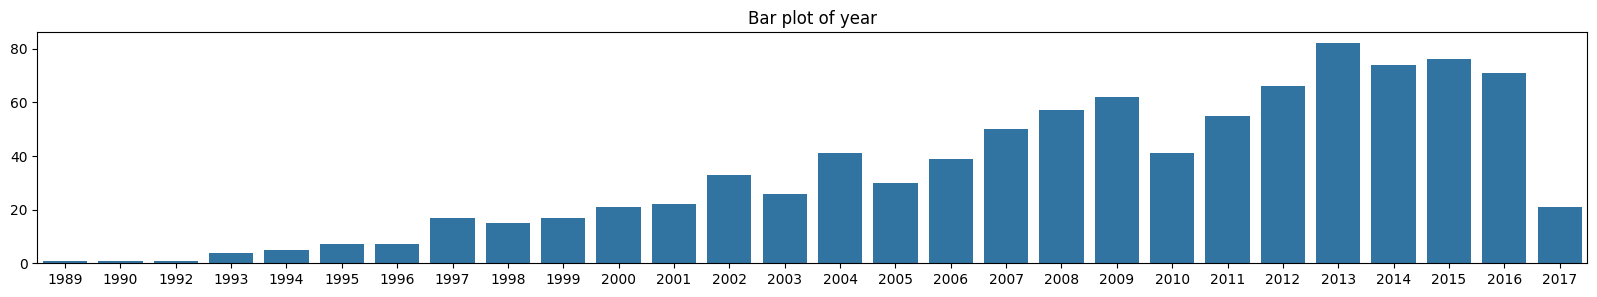

In [23]:
# make the bar plot of the year
plt.figure(figsize=(20,3))
sns.barplot(x=items, y=counts,)
plt.title("Bar plot of year")
plt.show()

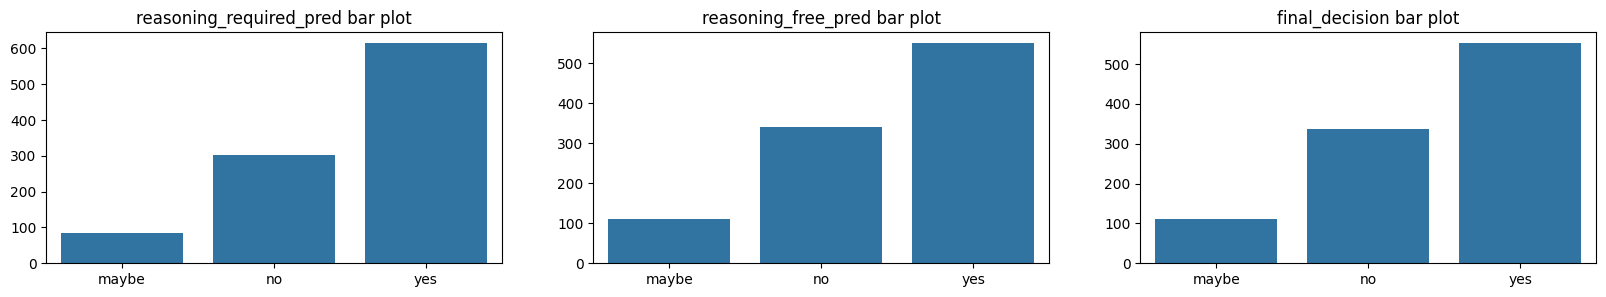

In [24]:
# bar chart for different features of the data
_, ax = plt.subplots(1, 3, figsize=(20,3))
ax = ax.ravel()

items, counts =  np.unique(reasoning_required_pred_ll, return_counts=True)
sns.barplot(x=items, y=counts, ax=ax[0])
ax[0].set_title("reasoning_required_pred bar plot")

items, counts =  np.unique(reasoning_free_pred_ll, return_counts=True)
sns.barplot(x=items, y=counts, ax=ax[1])
ax[1].set_title("reasoning_free_pred bar plot")

items, counts =  np.unique(final_decision_ll, return_counts=True)
sns.barplot(x=items, y=counts, ax=ax[2])
ax[2].set_title("final_decision bar plot")

plt.show()

### sentence length

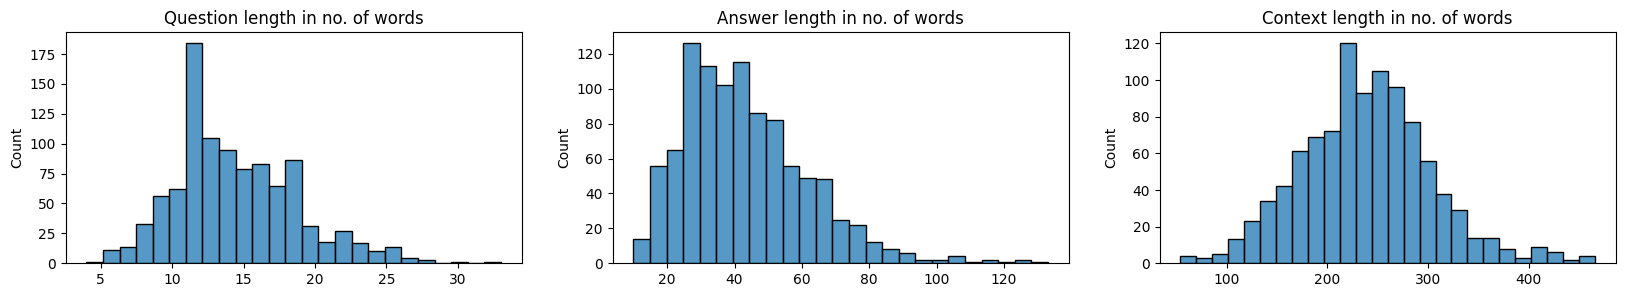

In [26]:
# measure text length in terms of no of words

qlen = [ len(word_tokenize(question)) for question in question_ll  ]
alen = [ len(word_tokenize(answer)) for answer in answer_ll  ]
clen = [ len(word_tokenize(context)) for context in context_ll  ]

_,ax = plt.subplots(1,3, figsize=(20,3))
ax = ax.ravel()

sns.histplot(qlen, ax=ax[0])
ax[0].set_title("Question length in no. of words")

sns.histplot(alen, ax=ax[1])
ax[1].set_title("Answer length in no. of words")

sns.histplot(clen, ax=ax[2])
ax[2].set_title("Context length in no. of words")

plt.show()

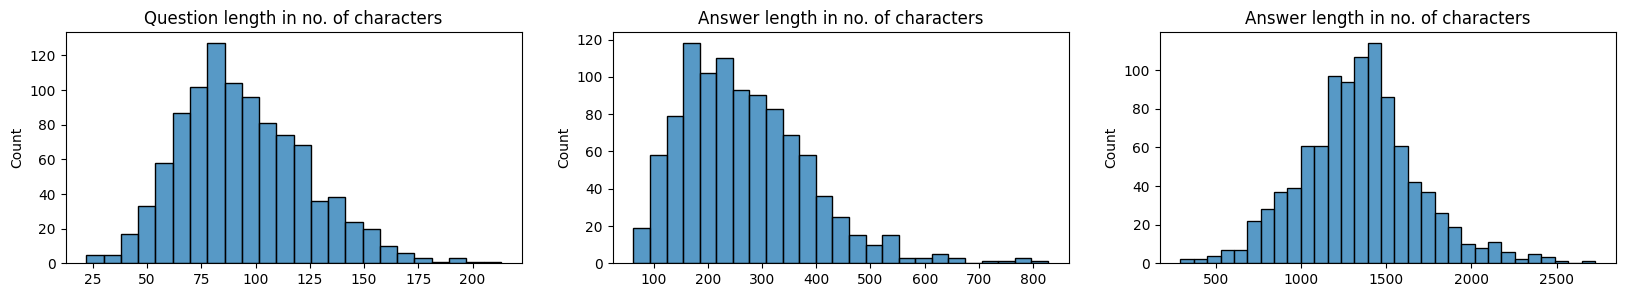

In [27]:
# measure text length in terms of no of characters

qlen_ch = [ len(question.strip()) for question in question_ll  ]
alen_ch = [ len(answer.strip()) for answer in answer_ll  ]
clen_ch = [ len(context) for context in context_ll  ]

_,ax = plt.subplots(1,3, figsize=(20,3))
ax = ax.ravel()

sns.histplot(qlen_ch, ax=ax[0])
ax[0].set_title("Question length in no. of characters")

sns.histplot(alen_ch, ax=ax[1])
ax[1].set_title("Answer length in no. of characters")

sns.histplot(clen_ch, ax=ax[2])
ax[2].set_title("Answer length in no. of characters")

plt.show()

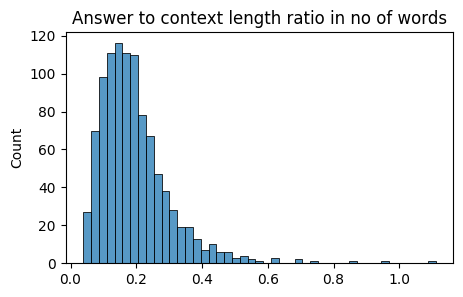

In [28]:
# histogram for answer length to context length in no of words
# values < 1.0 are have length smaller than context.

len_ratio_ll = [ x/y for x,y in zip(alen, clen)  ]

plt.figure(figsize=(5,3))
sns.histplot(len_ratio_ll)
plt.title("Answer to context length ratio in no of words")
plt.show()

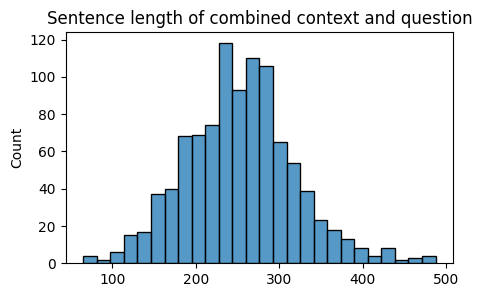

In [29]:
# sentence length of combined context and question
len_ratio_ca_ll = [ x+y for x,y in zip(qlen, clen)  ]

plt.figure(figsize=(5,3))
sns.histplot(len_ratio_ca_ll)
plt.title("Sentence length of combined context and question")
plt.show()

In [30]:
"Maximum length of combined context and questioin : " , np.max(len_ratio_ca_ll)

('Maximum length of combined context and questioin : ', np.int64(487))

### word frequency

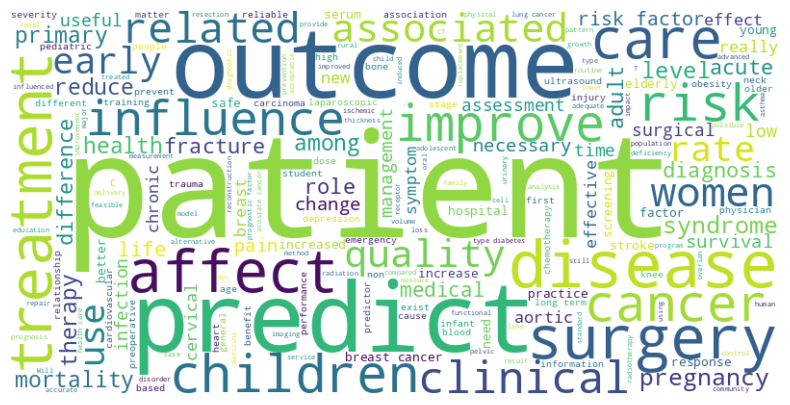

In [31]:
# Question text wordcloud

wcinp = " ".join( question_ll )
wci = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(wcinp)

plt.figure(figsize=(10, 5))
plt.imshow(wci, interpolation="bilinear")
# plt.title("Input Text Wordcloud")
plt.axis("off")
plt.show()

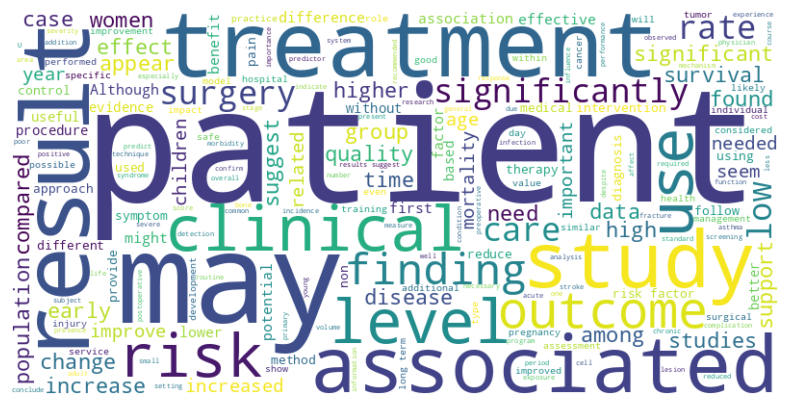

In [32]:
# Answer text wordcloud

wcinp = " ".join( answer_ll )
wci = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(wcinp)

plt.figure(figsize=(10, 5))
plt.imshow(wci, interpolation="bilinear")
plt.axis("off")
plt.show()

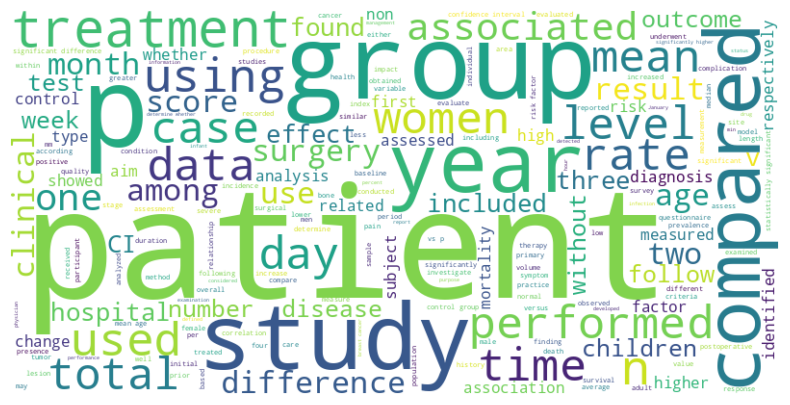

In [33]:
# Context text wordcloud

wcinp = " ".join( context_ll )
wci = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(wcinp)

plt.figure(figsize=(10, 5))
plt.imshow(wci, interpolation="bilinear")
plt.axis("off")
plt.show()

In [34]:
# Question vocabulary analysis

all_words = word_tokenize(" ".join( question_ll ).lower())
filtered_words_1 = [word for word in all_words if word.isalnum() ]
filtered_words = [word for word in filtered_words_1 if word not in stop_words]

total_words = len(all_words)
total_stop_words = len(filtered_words_1) - len(filtered_words)
word_counts = Counter(filtered_words)

print("Question text vocabulary analysis:")
print("Vocabulary size: ", len(word_counts))
print("Stop words ratio: ", total_stop_words/len(all_words) )

Question text vocabulary analysis:
Vocabulary size:  3474
Stop words ratio:  0.2869034406215316


In [35]:
# Answer vocabulary analysis

all_words = word_tokenize(" ".join( answer_ll ).lower())
filtered_words_1 = [word for word in all_words if word.isalnum() ]
filtered_words = [word for word in filtered_words_1 if word not in stop_words]

total_words = len(all_words)
total_stop_words = len(filtered_words_1) - len(filtered_words)
word_counts = Counter(filtered_words)

print("Answer text vocabulary analysis:")
print("Vocabulary size: ", len(word_counts))
print("Stop words ratio: ", total_stop_words/len(all_words) )

Answer text vocabulary analysis:
Vocabulary size:  6109
Stop words ratio:  0.35102985420041655


In [36]:
# Context vocabulary analysis

all_words = word_tokenize(" ".join( context_ll ).lower())
filtered_words_1 = [word for word in all_words if word.isalnum() ]
filtered_words = [word for word in filtered_words_1 if word not in stop_words]

total_words = len(all_words)
total_stop_words = len(filtered_words_1) - len(filtered_words)
word_counts = Counter(filtered_words)

print("Context text vocabulary analysis:")
print("Vocabulary size: ", len(word_counts))
print("Stop words ratio: ", total_stop_words/len(all_words) )

Context text vocabulary analysis:
Vocabulary size:  12695
Stop words ratio:  0.2846319847472187


In [37]:
# Question-Context concatenated vocabulary analysis

concat_question_answer_ll = [ x+y for x,y in zip(context_ll, question_ll) ]
all_words = word_tokenize(" ".join( concat_question_answer_ll ).lower())
filtered_words_1 = [word for word in all_words if word.isalnum() ]
filtered_words = [word for word in filtered_words_1 if word not in stop_words]

total_words = len(all_words)
total_stop_words = len(filtered_words_1) - len(filtered_words)
word_counts = Counter(filtered_words)

print("Question-Context concatenated text vocabulary analysis:")
print("Vocabulary size: ", len(word_counts))
print("Stop words ratio: ", total_stop_words/len(all_words) )

Question-Context concatenated text vocabulary analysis:
Vocabulary size:  12884
Stop words ratio:  0.2839492422132941


### Other analysis

**n-gram overlap analysis**

In [38]:
# function to get the n-grams from the context and the answer. Then to get the ratio of overlapping -
#   n-grams between the answer and the context.

def get_ngram_overlap(context, answer, ngram=2):

    context_tokens = [ word for word in word_tokenize(context.lower()) if word not in stop_words ]
    answer_tokens = [ word for word in word_tokenize(answer.lower()) if word not in stop_words ]

    context_ngrams = list(ngrams(context_tokens, ngram))
    answer_ngrams = list(ngrams(answer_tokens, ngram))

    overlap_ngrams = set(context_ngrams) & set(answer_ngrams)
    overlap_ratio = len(overlap_ngrams) / len(answer_ngrams)

    return overlap_ratio


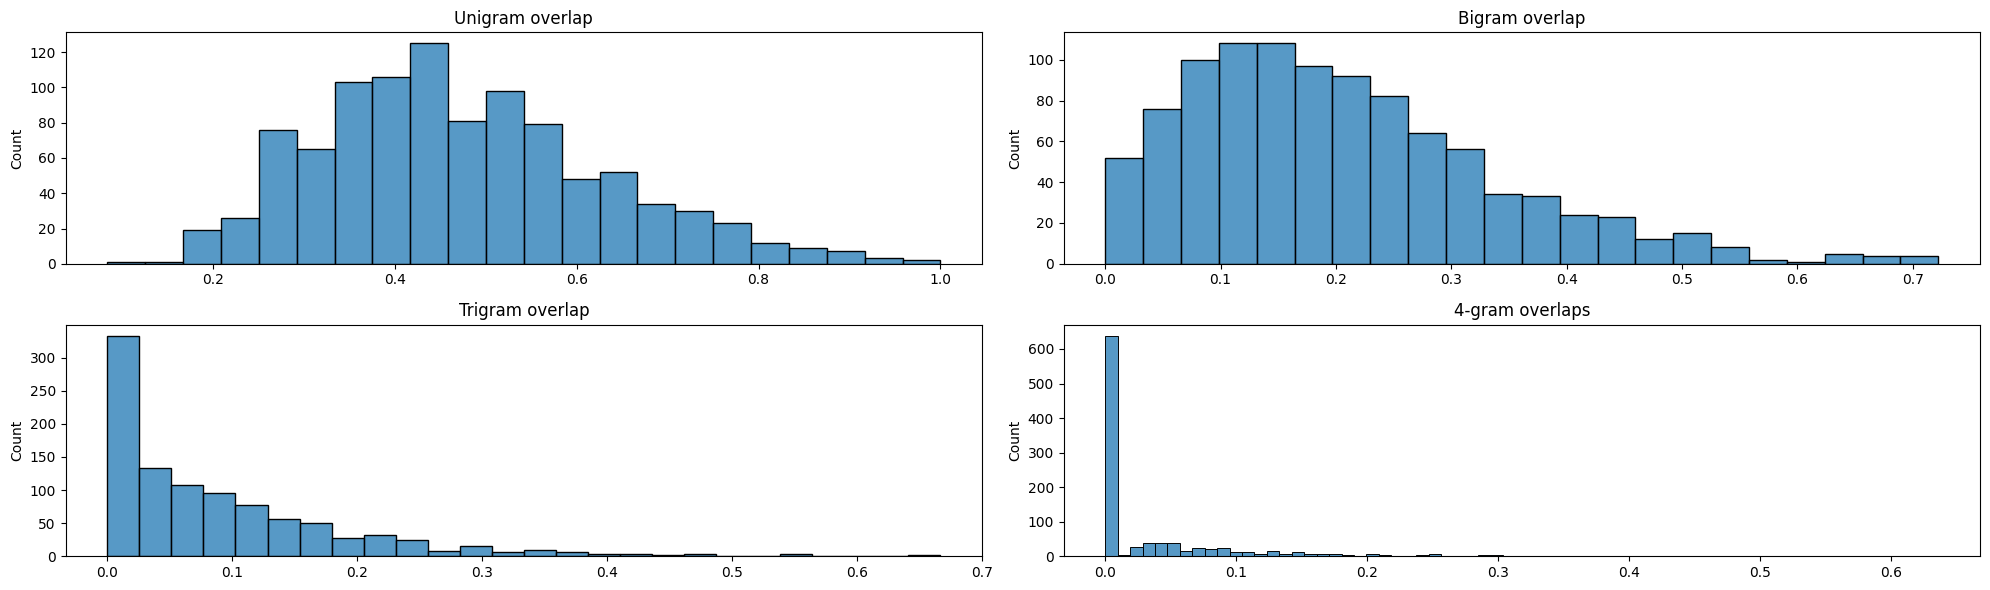

In [39]:
#  n-gram overlap analysis using unigram, bigram, trigram and 4-gram

overlap1_ratio_ll = [ get_ngram_overlap(context, answer, 1) for context, answer in zip(context_ll, answer_ll) ]
overlap2_ratio_ll = [ get_ngram_overlap(context, answer, 2) for context, answer in zip(context_ll, answer_ll) ]
overlap3_ratio_ll = [ get_ngram_overlap(context, answer, 3) for context, answer in zip(context_ll, answer_ll) ]
overlap4_ratio_ll = [ get_ngram_overlap(context, answer, 4) for context, answer in zip(context_ll, answer_ll) ]


_,ax = plt.subplots(2,2, figsize=(20,6))
ax = ax.ravel()

sns.histplot(overlap1_ratio_ll, ax=ax[0])
ax[0].set_title("Unigram overlap")

sns.histplot(overlap2_ratio_ll, ax=ax[1])
ax[1].set_title("Bigram overlap")

sns.histplot(overlap3_ratio_ll, ax=ax[2])
ax[2].set_title("Trigram overlap")

sns.histplot(overlap4_ratio_ll, ax=ax[3])
ax[3].set_title("4-gram overlaps")
plt.tight_layout()
plt.show()

**Jaccard Index for answer and context**

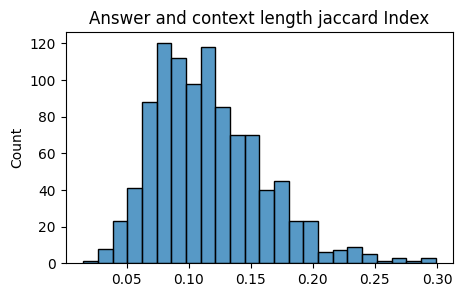

In [40]:
def get_jaccard_index(text_1, text_2):
    text_1 = [ word for word in word_tokenize(text_1.lower()) if word not in stop_words ]
    text_2 =  [ word for word in word_tokenize(text_2.lower()) if word not in stop_words ]

    text_1 = set(text_1)
    text_2 = set(text_2)

    common_words = text_1.intersection(text_2)
    union = text_1.union(text_2)

    return len(common_words) / len(union) if union else 0


jaci_ca_ll = [ get_jaccard_index(context, answer) for context, answer in zip(context_ll, answer_ll) ]


plt.figure(figsize=(5,3))
sns.histplot(jaci_ca_ll)
plt.title("Answer and context length jaccard Index")
plt.show()

**Question words analysis**

In [41]:
# get the no of wh questions in the question list

wh_question_words = { "who", "what", "where", "when", "why", "which", "whose", "whom", "how", }

def get_wh_word(text):
    text_ll = text.lower().split()
    for wh_word in wh_question_words:
        if wh_word in text_ll:
            return wh_word

    return ""


wh_word_dkt={}

for question in question_ll:
    word = get_wh_word(question)
    if len(word)!=0:
        if word in wh_word_dkt:
            wh_word_dkt[word]+=1
        else:
            wh_word_dkt[word]=1

total_wh_words = np.sum([ v for k,v in wh_word_dkt.items() ])


print(wh_word_dkt)
print("Total wh words questions : ", total_wh_words)

{'who': 7, 'what': 2, 'when': 8, 'which': 1, 'whose': 1, 'why': 1, 'where': 1}
Total wh words questions :  21


In [42]:
# top bigrams for the question list

questions_concat  = " ".join(question_ll)
bigrams = list(ngrams(word_tokenize(questions_concat.lower()), 2))
bigram_counts = Counter(bigrams)

for x in bigram_counts.most_common(20):
    print(x[0])

('?', 'does')
('?', 'is')
(':', 'is')
('?', 'can')
('?', 'do')
('?', 'are')
('of', 'the')
('in', 'the')
('patients', 'with')
('is', 'there')
(':', 'does')
(':', 'are')
('is', 'it')
('in', 'patients')
(':', 'a')
('is', 'the')
('does', 'the')
('there', 'a')
('cancer', '?')
(':', 'do')


### semantic similarity

In [43]:
model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [44]:
quesion_embed_ll = [ model.encode(text, convert_to_tensor=True) for text in question_ll ]
context_embed_ll = [ model.encode(text, convert_to_tensor=True) for text in context_ll ]

cos_sim_ll = [ util.pytorch_cos_sim(emb1, emb2).numpy()[0,0] for emb1, emb2 in zip(quesion_embed_ll, context_embed_ll)  ]

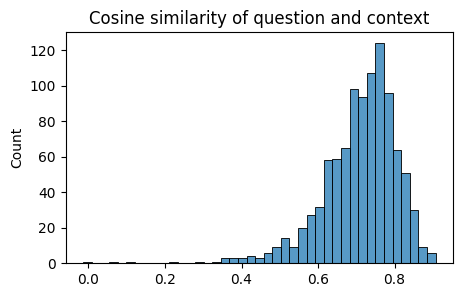

In [45]:
plt.figure(figsize=(5,3))
sns.histplot(cos_sim_ll)
plt.title("Cosine similarity of question and context")
plt.show()

# Save dataframe

In [46]:
df.to_csv("data.csv", index=False)